#Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#dataset preparation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128 # mini batch size
image_size = 28*28 # image size

transform = transform.Compose([
    transform.ToTensor(), # convert images to tensor
    transform.Normalize((0.5,), (0.5,)) # normalization -> compress between -1 and 1
])

# Loading the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# load the dataset in batches
dataLoader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


#Discriminator

In [ ]:
class Discriminator(nn.Module): # will try to understand whether the images produced by the generator are real or fake

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024), # input: image size, 1024: number of neurons, i.e. output of this layer
            nn.LeakyReLU(0.2), # activation function and slope of 0.2
            nn.Linear(1024, 512), # From 1024 to 512 nodes
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256), # From 512 to 256 nodes
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), # 256 to 1 node, output layer
            nn.Sigmoid() # sets the output between 0 and 1
            )

    def forward(self, img):
        return self.model(img.view(-1, image_size)) # flatten the image and give it to the model


#create generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256), # fully connected layer from input to 256 nodes
            nn.ReLU(),
            nn.Linear(256, 512), # From 256 to 512 nodes
            nn.ReLU(),
            nn.Linear(512, 1024), # From 512 to 1024 nodes
            nn.ReLU(),
            nn.Linear(1024, image_size), # From 1024 to 784 nodes
            nn.Tanh() # output activation function
            )


    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28) # Converts the output to a 28*28 image

#gan training

In [ ]:
# hyperparameters
lr_g = 0.0002 # genarator learning rate
lr_d = 0.0001 # discriminator learning rate
z_dim = 100 # random noise vector size
epochs = 50 # number of training cycles

# Model initialization: define generator and discriminator
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# definition of loss function and optimization algorithms
criterion = nn.BCELoss() # Binary Cross Entropy Loss
g_optimizer = optim.Adam(generator.parameters(), lr = lr_g, betas = (0.5, 0.999)) # generator
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr_d, betas = (0.5, 0.999)) # discriminator


# starting the training cycle
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataLoader): # uploading images
      real_imgs = real_imgs.to(device)
      batch_size = real_imgs.size(0) # get current batch size
      real_labels = torch.ones(batch_size, 1).to(device) # tag real images 1
      fake_labels = torch.zeros(batch_size, 1).to(device) # Tag fake images as 0

      # Discriminator training
      z = torch.randn(batch_size, z_dim).to(device) # generate random noise vector
      fake_imgs = generator(z) # creation of fake images
      real_loss = criterion(discriminator(real_imgs), real_labels) # loss of real images
      fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels) # loss of fake images
      d_loss = real_loss + fake_loss # total loss

      d_optimizer.zero_grad() # zeroing out gradients
      d_loss.backward()
      d_optimizer.step() # update parameters

      # generator training
      g_loss = criterion(discriminator(fake_imgs), real_labels) # loss of generator
      g_optimizer.zero_grad() # zeroing out gradients
      g_loss.backward()
      g_optimizer.step() # update parameters

    print(f"Epoch {epoch+1}/{epochs}, d_loss: {d_loss.item():.3f}, g_loss: {g_loss.item():.3f}")

Epoch 1/50, d_loss: 1.588, g_loss: 3.726
Epoch 2/50, d_loss: 0.644, g_loss: 2.346
Epoch 3/50, d_loss: 0.514, g_loss: 2.928
Epoch 4/50, d_loss: 0.638, g_loss: 1.774
Epoch 5/50, d_loss: 0.215, g_loss: 3.383
Epoch 6/50, d_loss: 0.135, g_loss: 3.658
Epoch 7/50, d_loss: 0.131, g_loss: 4.000
Epoch 8/50, d_loss: 0.577, g_loss: 2.724
Epoch 9/50, d_loss: 0.239, g_loss: 3.210
Epoch 10/50, d_loss: 0.290, g_loss: 1.863
Epoch 11/50, d_loss: 0.395, g_loss: 5.769
Epoch 12/50, d_loss: 0.150, g_loss: 3.967
Epoch 13/50, d_loss: 0.116, g_loss: 3.929
Epoch 14/50, d_loss: 0.065, g_loss: 5.540
Epoch 15/50, d_loss: 0.000, g_loss: 38.278
Epoch 16/50, d_loss: 0.494, g_loss: 2.450
Epoch 17/50, d_loss: 0.355, g_loss: 4.847
Epoch 18/50, d_loss: 3.895, g_loss: 9.314
Epoch 19/50, d_loss: 0.190, g_loss: 7.791
Epoch 20/50, d_loss: 0.190, g_loss: 3.437
Epoch 21/50, d_loss: 0.731, g_loss: 3.749
Epoch 22/50, d_loss: 0.559, g_loss: 3.932
Epoch 23/50, d_loss: 0.357, g_loss: 2.822
Epoch 24/50, d_loss: 0.735, g_loss: 1.887


#model testing and performance evaluation

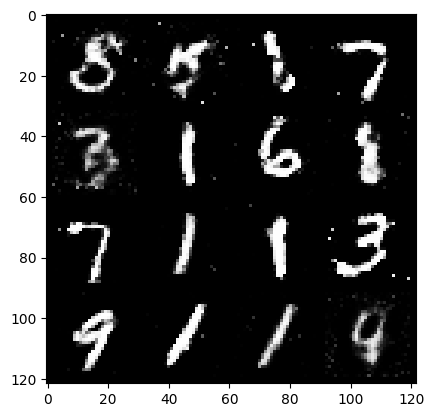

In [ ]:
# image generation with random noise
with torch.no_grad():
  z = torch.randn(16, z_dim).to(device) # Generate 16 random noises
  sample_imgs = generator(z).cpu() # Create a fake image with a generator
  grid = np.transpose(utils.make_grid(sample_imgs, nrow = 4, normalize = True), (1, 2, 0)) # arrange images in grid view
  plt.imshow(grid)
  plt.show()